# Classification automatique dans une nomenclature

Application de `Fasttext`

Cette application illustrera certains apports des outils du NLP pour la
codification automatique des déclarations d’activité dans la
nomenclature des activités françaises.

## Exploration du jeu de données

Ce tutoriel se propose d’illustrer la problématique de la classification
automatiquem par le biais de l’algorithme d’apprentissage supervisé
`Fasttext` à partir des données issues des déclarations Sirene.

Le code pour lire les données est directement fourni:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud

DATA_PATH = "https://minio.lab.sspcloud.fr/projet-formation/diffusion/mlops/data/firm_activity_data.parquet"
NAF_PATH = "https://www.insee.fr/fr/statistiques/fichier/2120875/naf2008_liste_n5.xls"
naf = pd.read_excel(NAF_PATH, skiprows = 2)
naf['Code'] = naf['Code'].str.replace(".","")
train = pd.read_parquet(DATA_PATH)
train = train.merge(naf, left_on = "nace", right_on = "Code")
train.head(5)

Le premier exercice a vocation à illustrer la manière classique de
rentrer dans un corpus de données textuelles. La démarche n’est pas
particulièrement originale mais permet d’illustrer les enjeux du
nettoyage de texte.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1 </h3>

1.  Créer une fonction pour compter le nombre d’occurrences d’un mot ou
    groupe donné dans le corpus. La tester avec *“data science”* et
    *“boulanger”*

2.  Faire une fonction pour afficher le *wordcloud* de notre corpus dans
    son ensemble et de certaines catégories pour comprendre la nature de
    notre corpus.

3.  Retirer les stopwords à partir de la liste des mots disponibles dans
    `SpaCy`

<details>

<summary>

Aide

</summary>

``` python
from nltk.tokenize import word_tokenize
import spacy

nlp = spacy.load("fr_core_news_sm")
stop_words = #liste de stopwords

# Function to remove stopwords
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def remove_single_letters(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if len(word) > 1]
    return ' '.join(filtered_text)

# Apply the function to the 'text' column
train['text_clean'] = (train['text']
    .apply(remove_stopwords)
    .apply(remove_single_letters)
)
```

</details>

1.  Refaire quelques uns des nuages de mots et étudier la différence
    avant nettoyage

</div>

Dans une démarche exploratoire, le plus simple est de commencer par
compter les mots de manière indépendante (approche sac de mot). Par
exemple, de manière naturelle, nous avons beaucoup plus de déclarations
liées à la boulangerie que liées à la *data science*:

In [3]:
nb_occurrence(train, "data science").head(5)
nb_occurrence(train, "boulanger").head(5)

Nombre d'occurrences du terme 'data science': 54
Nombre d'occurrences du terme 'boulanger': 1928

Les *wordcloud* peuvent servir à rapidement visualiser la structure d’un
corpus. On voit ici que notre corpus est très bruité car nous n’avons
pas nettoyé celui-ci:

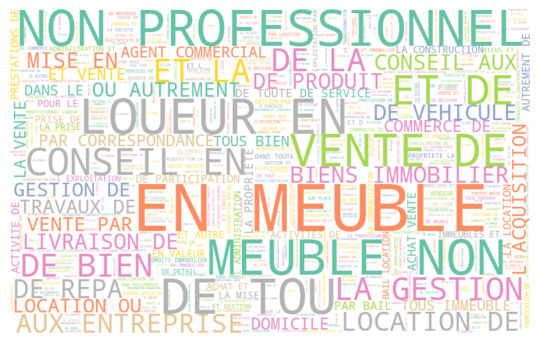

Pour commencer à se faire une idée sur les spécificités des catégories,
on peut représenter le corpus de certaines d’entre elles ? Arrivez-vous
à inférer la catégorie de la NAF en question ? Si oui, vous utilisez
sans doute des heuristiques proches de celles que nous allons mettre en
oeuvre dans notre algorithme de classification

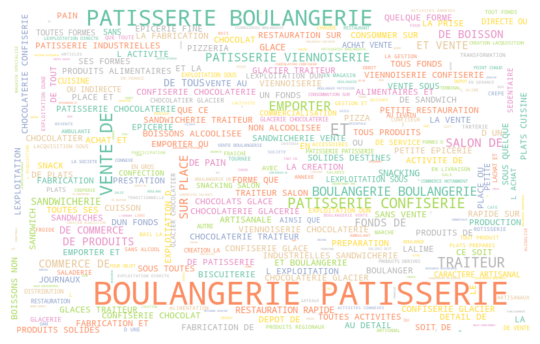

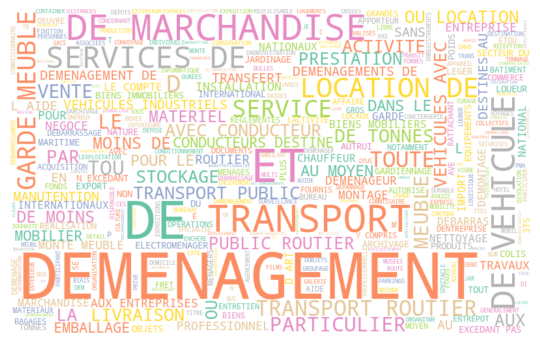

Néanmoins, à ce stade, les données sont encore très bruitées. La
première étape classique est de retirer les *stop words* et
éventuellement des termes spécifiques à notre corpus. Par exemple, pour
des données de caisse, on retirera les bruits, les abbréviations, etc.
qui peuvent bruiter notre corpus.

## Premier algorithe d’apprentissage supervisé

Nous avons nettoyé nos données. Cela devrait améliorer la pertinence de
nos modèles en réduisant le ratio signal/bruit. Nous allons généraliser
notre nettoyage de texte en appliquant un peu plus d’étapes que
précédemment. Nous allons notamment raciniser nos mots.

Pour cela, récupérer les fichiers suivants:

-   [`constants.py`]()
-   [`preprocessor.py`]()
-   [`utils.py`]()

et mettre ceux-ci dans le même dossier que votre *notebook* `Jupyter`

Le code de nettoyage est directement fourni

In [9]:
from processor import Preprocessor
preprocessor = Preprocessor()

# Preprocess data before training and testing
TEXT_FEATURE = "text"
Y = "nace"

df = preprocessor.clean_text(train, TEXT_FEATURE).drop('text_clean', axis = "columns")
df.head(2)

Nous allons commencer à entraîner un modèle dont le plongement de mot
est de faible dimension. Voici les paramètres qui seront utiles pour le
prochain exercice

In [10]:
import pathlib

params = {
    "dim": 25,
    "label_prefix": "__label__"
}

data_path = pathlib.Path("./data")
data_path.mkdir(parents=True, exist_ok=True)

def write_training_data(df, params, training_data_path=None):
    warnings.filterwarnings("ignore", "Setuptools is replacing distutils.")
    if training_data_path is None:
        training_data_path = get_root_path() / "data/training_data.txt"

    with open(training_data_path, "w", encoding="utf-8") as file:
        for _, item in df.iterrows():
            formatted_item = f"{params['label_prefix']}{item[Y]} {item[TEXT_FEATURE]}"
            file.write(f"{formatted_item}\n")
    return training_data_path.as_posix()

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 2 </h3>

1.  Découper notre échantillon complet en *train* et *test*
2.  `Fasttext` effectue son entraînement à partir d’objets stockés dans
    un `.txt`. Utiliser la fonction `write_training_data` de la manière
    suivante pour l’écrire

``` python
# Write training data in a .txt file (fasttext-specific)
training_data_path = write_training_data(df_train, params, pathlib.Path(str(data_path.absolute()) + "/training_data.txt"))
```

1.  Avec l’aide de la documentation de la librairie `Python`, entraîner
    votre modèle de classification.

2.  Sauvegarder le modèle sous forme de binaire, cela pourra
    éventuellement servir ultérieurement.

3.  Renvoyer les trois catégories les plus probables pour les nouveaux
    libellés suivants:

``` python
list_libs = ["vendeur d'huitres", "boulanger"]
```

1.  Sur l’ensemble du jeu de test, renvoyer la meilleure prédiction pour
    chaque descriptif d’activités. Evaluer la performance globale et la
    performance classe par classe (pour les classes de plus de 200 cas).

</div>

Read 1M wordsRead 2M wordsRead 3M wordsRead 4M wordsRead 4M words
Number of words:  26820
Number of labels: 699
Progress:   0.4% words/sec/thread:    6261 lr:  0.099620 avg.loss:  9.851038 ETA:   0h 0m38sProgress:   0.5% words/sec/thread:    4588 lr:  0.099459 avg.loss:  8.382147 ETA:   0h 0m52sProgress:   0.8% words/sec/thread:    4570 lr:  0.099151 avg.loss:  6.997760 ETA:   0h 0m52sProgress:   1.0% words/sec/thread:    4423 lr:  0.098994 avg.loss:  6.580428 ETA:   0h 0m53sProgress:   1.2% words/sec/thread:    4314 lr:  0.098838 avg.loss:  6.028551 ETA:   0h 0m55sProgress:   1.3% words/sec/thread:    4221 lr:  0.098688 avg.loss:  5.713104 ETA:   0h 0m56sProgress:   1.5% words/sec/thread:    4183 lr:  0.098524 avg.loss:  5.418303 ETA:   0h 0m56sProgress:   1.6% words/sec/thread:    4144 lr:  0.098366 avg.loss:  5.112319 ETA:   0h 0m57sProgress:   1.8% words/sec/thread:    4111 lr:  0.098207 avg.loss:  4.919856 ETA:   0h 0m57sProgress:   1.9% words/sec/thread:    4075 lr:  0.098052 avg

127 rows × 3 columns

/opt/mamba/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 12'. Pick better value with 'binwidth'.

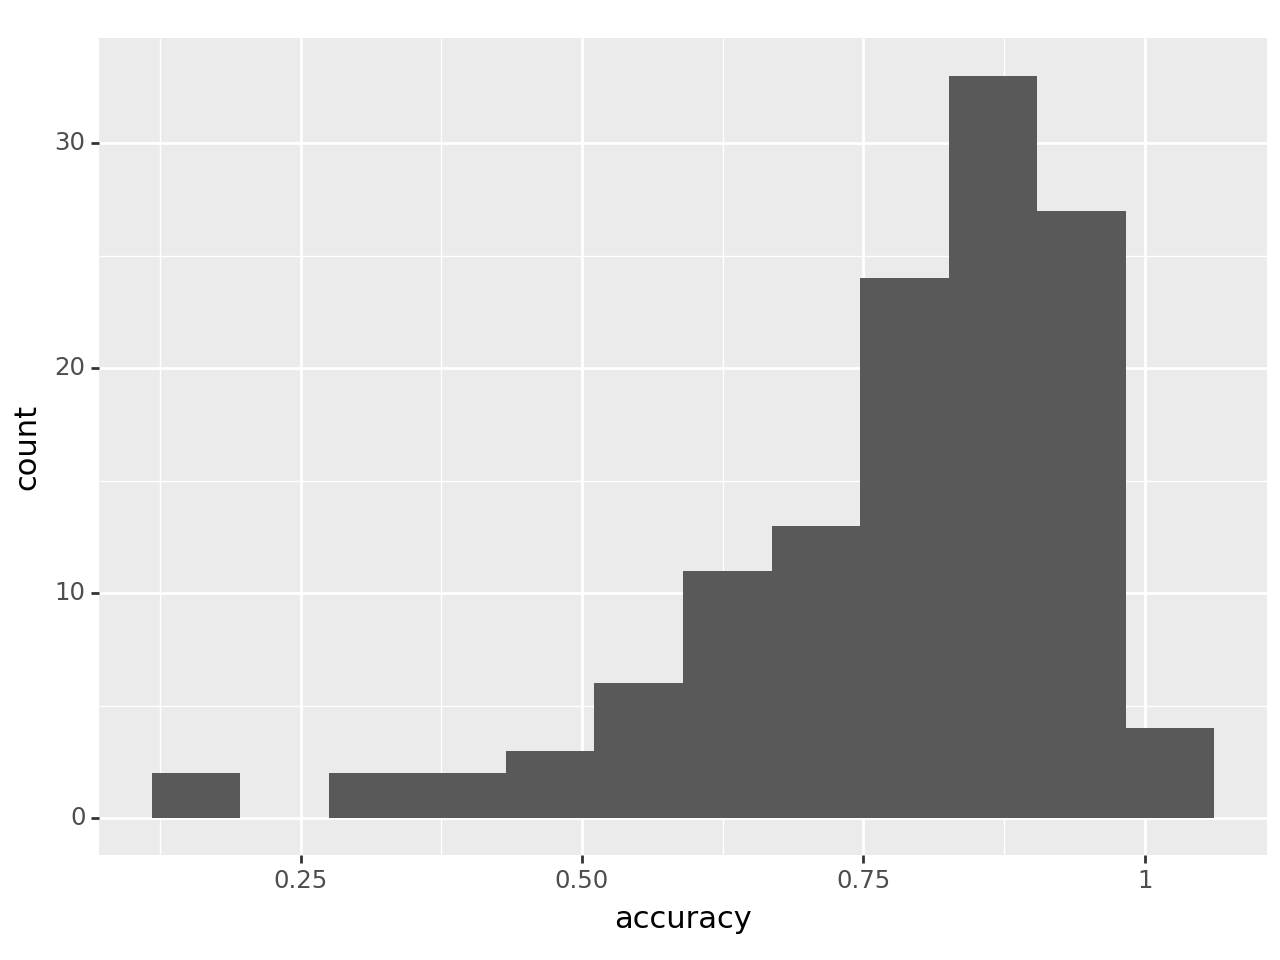